In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient
from glob import glob
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

2023-02-10 15:30:53.036513: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-10 15:30:53.036627: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
GCS_DS_PATH = KaggleDatasets().get_gcs_path('website-defacement')

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
N_JOBS = cpu_count()

IMG_SIZE = 224
EPOCHS = 50

print('N_JOBS:', N_JOBS)
print('Batch size:', BATCH_SIZE)
print('GCS_DS_PATH:', GCS_DS_PATH)

Running on TPU: grpc://10.0.0.2:8470


2023-02-10 15:30:58.853817: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-10 15:30:58.856152: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-10 15:30:58.856184: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-10 15:30:58.856212: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d2ea0dcf5b67): /proc/driver/nvidia/version does not exist
2023-02-10 15:30:58.859151: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

N_JOBS: 4
Batch size: 64
GCS_DS_PATH: gs://kds-bdc1a4e6ec4ae5d9f2813149cb499f1a9df02b5e068427f000f5bb8e


In [3]:
dataset_path = '../input/website-defacement/'
img_paths = glob(dataset_path + 'image/*/*')
txt_paths = glob(dataset_path + 'text/*/*')
img_names = [path.split('/')[-1][:-4] for path in img_paths]
txt_names = [path.split('/')[-1][:-4] for path in txt_paths]
names = list(set(img_names).intersection(txt_names))

# Text-based Detection

In [4]:
def prepare_data(name):
    if glob(dataset_path + f'text/defaced/{name}.txt'):
        path = dataset_path + f'text/defaced/{name}.txt'
        label = 1
    else:
        path = dataset_path + f'text/benign/{name}.txt'
        label = 0
    with open(path, 'r') as f:
        text = f.read()
    return (text, label)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, 
                                                      random_state=42)

print(len(X_train), len(X_valid), len(X_test))

  0%|          | 0/96234 [00:00<?, ?it/s]

57740 19247 19247


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(X_train)

MAXLEN = 128

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAXLEN)
y_train = np.array(y_train)

X_valid = tokenizer.texts_to_sequences(X_valid)
X_valid = pad_sequences(X_valid, maxlen=MAXLEN)
y_valid = np.array(y_valid)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=MAXLEN)
y_test = np.array(y_test)

In [6]:
train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_train, y_train))
    .shuffle(100000)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices(X_test)
    .batch(BATCH_SIZE)
)

valid_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_valid, y_valid))
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

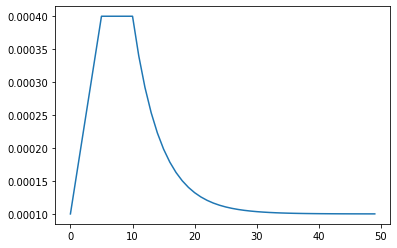

In [7]:
def lrfn(epoch=EPOCHS,
         lr_start=1e-4,
         lr_max=5e-5 * 8, 
         lr_min=1e-4,
         lr_rampup_epochs=5,
         lr_sustain_epochs=5,
         lr_exp_decay=0.8):
    if epoch < lr_rampup_epochs:
        lr = (lr_max-lr_start)/lr_rampup_epochs*epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max-lr_min)*lr_exp_decay**(epoch-lr_rampup_epochs-lr_sustain_epochs) + lr_min
    return lr

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

y = [lrfn(x) for x in range(EPOCHS)]
plt.plot(y)

### Text_CNN

In [8]:
vocab_size = len(tokenizer.word_index) + 1

with strategy.scope():
    model = Sequential()
    model.add(L.Embedding(input_dim=vocab_size,
                          output_dim=64, 
                          input_length=X_train.shape[1]))
    model.add(L.Conv1D(64, 5))
    model.add(L.GlobalMaxPooling1D())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 64)           181105280 
_________________________________________________________________
conv1d (Conv1D)              (None, 124, 64)           20544     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 181,125,954
Trainable params: 181,125,954
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('text-cnn.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[lrs, mc], 
                 validation_data=valid_dataset, verbose=2)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 181105280 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 39s - loss: 0.1546 - accuracy: 0.9346 - val_loss: 0.1027 - val_accuracy: 0.9653
Epoch 2/50
902/902 - 32s - loss: 0.0201 - accuracy: 0.9934 - val_loss: 0.1096 - val_accuracy: 0.9677
Epoch 3/50
902/902 - 32s - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.1150 - val_accuracy: 0.9670
Epoch 4/50
902/902 - 32s - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.1143 - val_accuracy: 0.9674
Epoch 5/50
902/902 - 32s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1138 - val_accuracy: 0.9671
Epoch 6/50
902/902 - 32s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.1159 - val_accuracy: 0.9670
Epoch 7/50
902/902 - 32s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.1177 - val_accuracy: 0.9667
Epoch 8/50
902/902 - 32s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.1184 - val_accuracy: 0.9667
Epoch 9/50
902/902 - 33s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.1185 - val_accuracy: 0.9665
Epoch 10/50
902/902 - 32s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.1180 - val_accuracy: 0.9665


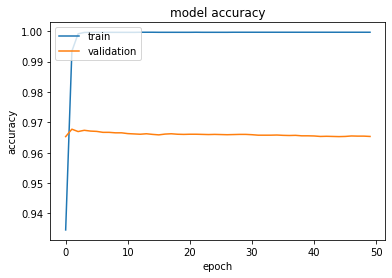

In [10]:
plot_hist(hist)

In [11]:
with strategy.scope():
    model.load_weights('text-cnn.h5')

y_prob_txt = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_txt, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_txt[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_txt[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 4s 10ms/step
              precision    recall  f1-score   support

           0     0.9581    0.9884    0.9730     11454
           1     0.9821    0.9365    0.9587      7793

    accuracy                         0.9674     19247
   macro avg     0.9701    0.9624    0.9659     19247
weighted avg     0.9678    0.9674    0.9672     19247

[[11321   133]
 [  495  7298]]
      TPR       FPR       FNR   ROC AUC
   0.9365    0.0116    0.0635    0.9945


### Text-RNN


In [12]:
vocab_size = len(tokenizer.word_index) + 1

with strategy.scope():
    model = Sequential()
    model.add(L.Embedding(input_dim=vocab_size,
                          output_dim=64, 
                          input_length=X_train.shape[1]))
    model.add(L.SimpleRNN(64,return_sequences=True,unroll=True))
    model.add(L.GlobalMaxPooling1D())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 64)           181105280 
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128, 64)           8256      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 181,113,666
Trainable params: 181,113,666
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('text-rnn.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], verbose=2,
                 validation_data=valid_dataset, 
                 )

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 181105280 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 54s - loss: 0.1975 - accuracy: 0.9179 - val_loss: 0.0924 - val_accuracy: 0.9651
Epoch 2/50
902/902 - 34s - loss: 0.0293 - accuracy: 0.9903 - val_loss: 0.1026 - val_accuracy: 0.9678
Epoch 3/50
902/902 - 33s - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.1242 - val_accuracy: 0.9656
Epoch 4/50
902/902 - 33s - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.1293 - val_accuracy: 0.9664
Epoch 5/50
902/902 - 33s - loss: 0.0017 - accuracy: 0.9997 - val_loss: 0.1260 - val_accuracy: 0.9674
Epoch 6/50
902/902 - 33s - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.1280 - val_accuracy: 0.9672
Epoch 7/50
902/902 - 33s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1368 - val_accuracy: 0.9670
Epoch 8/50
902/902 - 33s - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.1443 - val_accuracy: 0.9658
Epoch 9/50
902/902 - 33s - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.1533 - val_accuracy: 0.9642
Epoch 10/50
902/902 - 33s - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.1563 - val_accuracy: 0.9643


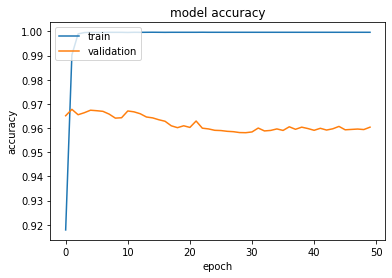

In [14]:
plot_hist(hist)

In [15]:
with strategy.scope():
    model.load_weights('text-rnn.h5')

y_prob_txt = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_txt, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_txt[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_txt[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 8s 19ms/step
              precision    recall  f1-score   support

           0     0.9611    0.9824    0.9716     11454
           1     0.9732    0.9416    0.9572      7793

    accuracy                         0.9659     19247
   macro avg     0.9672    0.9620    0.9644     19247
weighted avg     0.9660    0.9659    0.9658     19247

[[11252   202]
 [  455  7338]]
      TPR       FPR       FNR   ROC AUC
   0.9416    0.0176    0.0584    0.9945


### Text_LSTM


In [16]:
vocab_size = len(tokenizer.word_index) + 1

with strategy.scope():
    model = Sequential()
    model.add(L.Embedding(input_dim=vocab_size,
                          output_dim=64, 
                          input_length=X_train.shape[1]))
    model.add(L.LSTM(64, return_sequences=True))
    model.add(L.GlobalMaxPooling1D())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 64)           181105280 
_________________________________________________________________
lstm (LSTM)                  (None, 128, 64)           33024     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 181,138,434
Trainable params: 181,138,434
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('text-lstm.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[lrs, mc], 
                 validation_data=valid_dataset, verbose=2)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 181105280 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 42s - loss: 0.1667 - accuracy: 0.9281 - val_loss: 0.0918 - val_accuracy: 0.9657
Epoch 2/50
902/902 - 34s - loss: 0.0258 - accuracy: 0.9918 - val_loss: 0.1043 - val_accuracy: 0.9668
Epoch 3/50
902/902 - 33s - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.1177 - val_accuracy: 0.9672
Epoch 4/50
902/902 - 33s - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.1340 - val_accuracy: 0.9665
Epoch 5/50
902/902 - 33s - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.1468 - val_accuracy: 0.9653
Epoch 6/50
902/902 - 33s - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.1453 - val_accuracy: 0.9657
Epoch 7/50
902/902 - 33s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1588 - val_accuracy: 0.9655
Epoch 8/50
902/902 - 33s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1477 - val_accuracy: 0.9663
Epoch 9/50
902/902 - 33s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.1863 - val_accuracy: 0.9643
Epoch 10/50
902/902 - 33s - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.2036 - val_accuracy: 0.9635


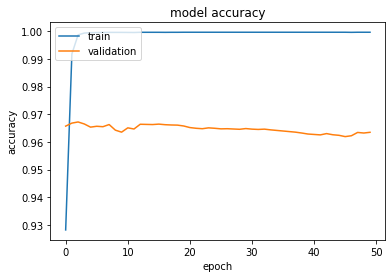

In [18]:
plot_hist(hist)

In [19]:
with strategy.scope():
    model.load_weights('text-lstm.h5')

y_prob_txt = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_txt, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_txt[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_txt[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 5s 11ms/step
              precision    recall  f1-score   support

           0     0.9605    0.9861    0.9732     11454
           1     0.9788    0.9405    0.9592      7793

    accuracy                         0.9676     19247
   macro avg     0.9697    0.9633    0.9662     19247
weighted avg     0.9679    0.9676    0.9675     19247

[[11295   159]
 [  464  7329]]
      TPR       FPR       FNR   ROC AUC
   0.9405    0.0139    0.0595    0.9952
